In [2]:
from pydub import AudioSegment
import os

### Loading file
Có thể dùng nhiều thư viện:
- librosa
- scipy
- torchaudio

In [3]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

In [93]:
AUDIO_PATH = 'dataset/speech010001.wav'

sample_rate, signal = scipy.io.wavfile.read(AUDIO_PATH)  # File assumed to be in the same directory
signal = signal[:144000,0]
print('samples: \n', signal)  # as a numpy.ndarray
print('sample_shape: ', signal.shape) #384000 = 48000*8 (8s)
print('sample_rate: ', sample_rate) # 48000


samples: 
 [ 435  698  796 ... 2906 2863 2859]
sample_shape:  (144000,)
sample_rate:  48000


### Display

In [94]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

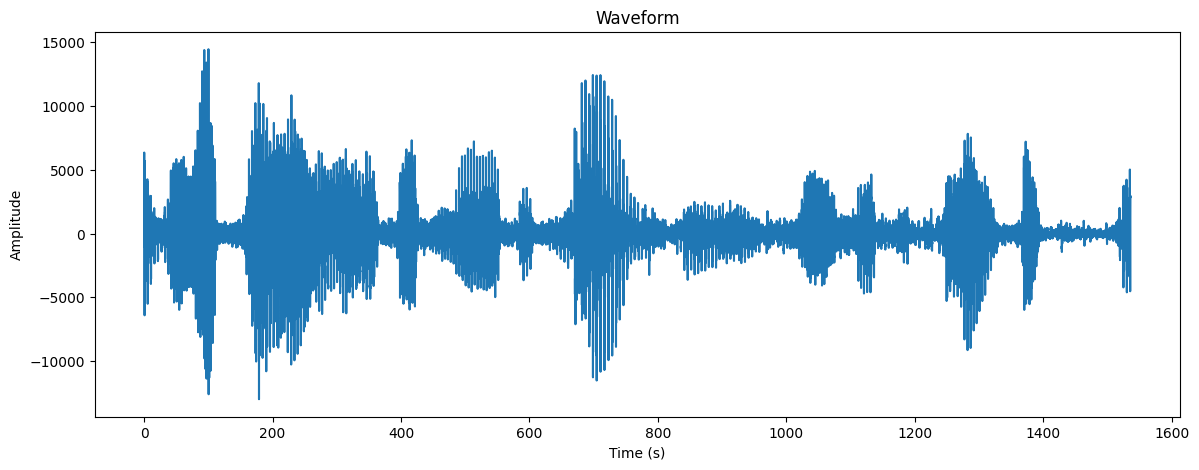

In [95]:
time = librosa.times_like(signal, sr=sample_rate)
plt.figure(figsize=(14, 5))
plt.plot(time, signal)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## ***Pre-Emphasis***
The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).

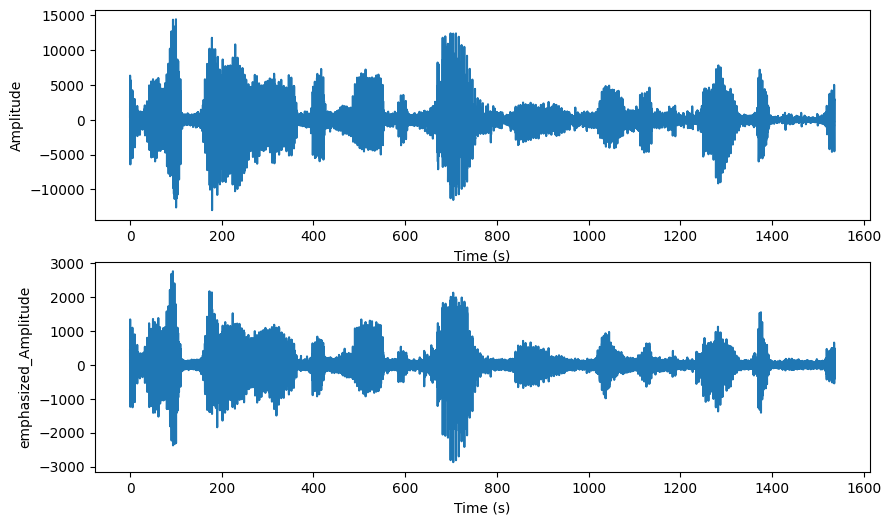

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

In [96]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])



fig, axs = plt.subplots(2, 1, figsize=(10, 6))

time = librosa.times_like(signal, sr=sample_rate)
plt.figure(figsize=(14, 5))
axs[0].plot(time, signal)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

plt.figure(figsize=(14, 5))
axs[1].plot(time, emphasized_signal)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('emphasized_Amplitude')

plt.show()

## ***Framing***

In [97]:
frame_size = 0.025
frame_stride =0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples, 1 frame contains 1200 samples
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

signal_length = len(emphasized_signal)
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

#Padding
pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

#indices.shape = (798, 1200)
indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]
print(frames.shape)
print(indices)


(298, 1200)
[[     0      1      2 ...   1197   1198   1199]
 [   480    481    482 ...   1677   1678   1679]
 [   960    961    962 ...   2157   2158   2159]
 ...
 [141600 141601 141602 ... 142797 142798 142799]
 [142080 142081 142082 ... 143277 143278 143279]
 [142560 142561 142562 ... 143757 143758 143759]]


## ***Window***
Do framing làm rời rạc hóa speech signal ta sẽ áp dụng một hàm gọi là Hamming Window để làm smooth các frames <br>
<br>
$w[n] = 0.54 − 0.46 cos ( \frac{2πn}{N − 1} )$

In [98]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

## ***Fourier-Transform and Power Spectrum***
### Convert to Spectrum by Fast Fourier Transform - FFT
Chuyển từ miền thời gian sang miền tần số. Nhưng điều này làm mất thông tin về thời gian, có thể dùng:
- from scipy.fft import fft, fftfreq
- from numpy.fft import fft, ifft

### Power Spectrum:
$P = \frac{|FFT(x_i)|^2}{N}$ <br> <br>
We can now do an N -point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where N
 is typically 256 or 512


In [99]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
print(mag_frames.shape)

(298, 257)


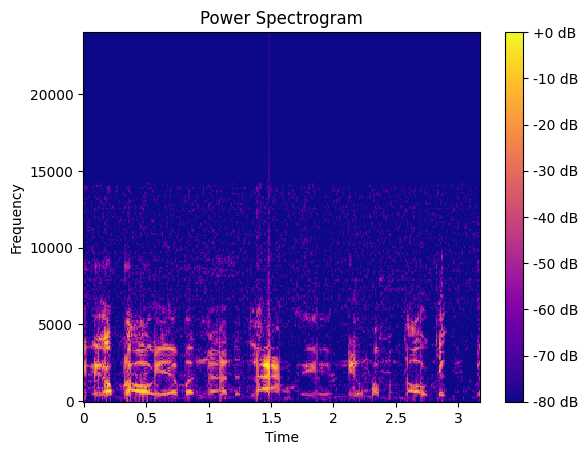

In [108]:
librosa.display.specshow(librosa.amplitude_to_db(pow_frames.T, ref=np.max), sr=sample_rate, x_axis='time', y_axis='linear', cmap = 'plasma')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# ***Mel filterbank***
### Chuyển thang đo giữa Hertz và Mel
$m = 2595 \log_{10} (1 + \frac{f}{700})$<br> <br>
$f = 700 (10^{m/2595} - 1)$

### Filter bank on a Mel-Scale
$H_m(k) = $
\begin{cases}
0 & \text{if }k < f(m - 1) \\
\dfrac{k - f(m - 1)}{f(m) - f(m - 1)} & \text{if } f(m - 1) \leq k < f(m) \\
1 & \text{if } k = f(m) \\
\dfrac{f(m + 1) - k}{f(m + 1) - f(m)} & \text{if } f(m) < k \leq f(m + 1) \\
0 & \text{if } k > f(m + 1)
\end{cases}

In [109]:
nfilt = 40
low_freq_mel = 0
#Conversion between Mel and Hz scale
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

# Creating the filterbank:
fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
print(fbank.shape)
#Applying the filterbanks to the power spectrum:
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

# filter_banks containing the Mel filterbank coefficients
##which are often used as features for speech and audio processing tasks.
print(filter_banks.shape)

(40, 257)
(298, 40)


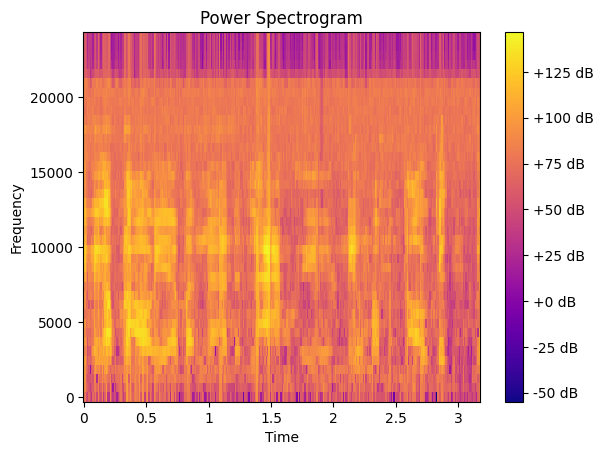

In [110]:
librosa.display.specshow(filter_banks.T, sr=sample_rate, x_axis='time', y_axis='linear', cmap = 'plasma')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# ***Mel-frequency Cepstral Coefficients (MFCCs)***

In [111]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

cep_lifter = 22
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

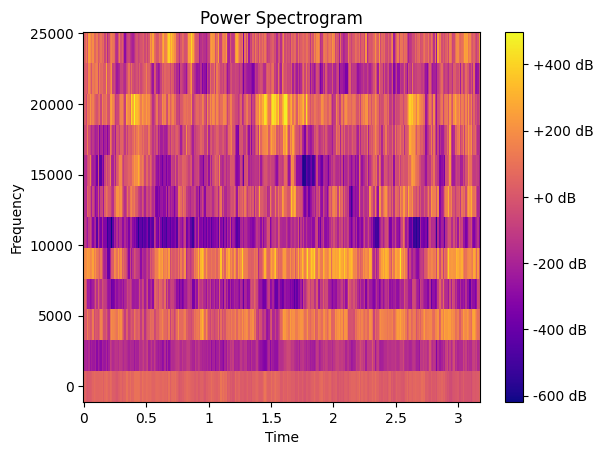

(298, 12)


In [112]:
librosa.display.specshow(mfcc.T, sr=sample_rate, x_axis='time', y_axis='linear', cmap = 'plasma')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()
print(mfcc.shape)